# Iridates Spectrum Fitting

From Seokhwan's Mathematica Code: <br>
DOSBG[V_, c0_, c1_, c2_, c3_] := c0 V^3 + c1 V^2 + c2 V + c3 <br>
DOSMott[V_, c4_, M_, E0_, w_] := c4  (1 - Abs[1/(1 + E^((V - E0)/w)) - 1/(1 + E^((V + E0 - M)/w))]) <br>
DOSPseu[V_, c5_, P_, a_] := If[V >= 0, c5 Abs[(V + I a Sqrt[V])/Sqrt[(V + I a Sqrt[V])^2 - (P)^2]], 
                            c5 Abs[(Abs[V] + I a Sqrt[Abs[V]])/ Sqrt[(Abs[V] + I a Sqrt[Abs[V]])^2 - (P)^2]]]

w := 0.015 <br>
E0 := 0.1 <br>

Plot[{DOSBG[V, c0, c1, c2, c3] + DOSMott[V, c4, M, E0, w] + DOSPseu[V, c5, P, a], DOSMott[V, c4, M, E0, w],DOSPseu[V, c5, P, a], DOSBG[V, c0, c1, c2, c3]}, {V, -1, 1}, PlotRange -> {0, 2}]<br>
<br>
Plot[
 DOSPseu[V, c5, P, a], {V, -1, 1}, PlotRange -> {-0.1, 1}]
Plot[
 DOSMott[V, c4, M, E0, w], {V, -1, 1}, PlotRange -> {-0.1, 1}]
Plot[
 DOSBG[V, c0, c1, c2, c3], {V, -1, 1}, PlotRange -> {-0.1, 1}]<br>
 
 end of Seokhwan's Mathematica code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
from scipy import optimize
from matplotlib import colors
from tqdm import tqdm

%matplotlib notebook

In [3]:
#DOS cubic background: f(V)
def DOS_B(params, V): # params = [c0, c1, c2, c3]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    return c0*V**3 + c1*V**2 + c2*V + c3

#DOS Mott: f(V)
def DOS_M(params, V):# params = [c4, M]
    c4 = params[0]
    M = params[1]
    E0 = 0.52 #initial attempt was 0.1, changed after manually adjusting to our data
    w = 0.02 #initial attempt was 0.015, changed after manually adjusting to our data
    return c4*(1 - np.abs(1 / np.exp((V-E0) / w) - 1 / (1+np.exp((-V+E0-M) / w))))

#DOS Pseudogap: f(V)
def DOS_P(params, V):# params = [c5, P, a]
    c5 = params[0]
    P = params[1]
    a = params[2]
    
    answer = np.array(c5*np.abs( (np.abs(V) + 1j*a*np.sqrt(np.abs(V))) / np.sqrt( ( np.abs(V) + 1j*a*np.sqrt(np.abs(V)))**2 - P**2)))
    return answer.real #Taking only the real part of the function

In [4]:
# DOS B + M:
def DOS_BM(params, V): # params = [c0, c1, c2, c3, c4, M]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c4 = params[4]
    M = params[5]
    
    background = DOS_B([c0, c1, c2, c3], V)
    mott = DOS_M([c4, M], V)
    
    sum_bm = [background[i]+mott[i] for i in range(len(V))]
    return sum_bm

#DOS B + P:
def DOS_BP(params, V): # params = [c0, c1, c2, c3, c5, P, a]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c5 = params[4]
    P = params[5]
    a = params[6]
    
    background = DOS_B([c0, c1, c2, c3], V)
    pseudogap = DOS_P([c5, P, a], V)
    
    sum_bp = [background[i]+pseudogap[i] for i in range(len(V))]
    return sum_bp

#DOS B + M + P:
def DOS_BMP(params, V): # params = [c0, c1, c2, c3, c4, M, c5, P, a]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c4 = params[4]
    M = params[5]
    c5 = params[6]
    P = params[7]
    a = params[8]
    
    background = DOS_B([c0, c1, c2, c3], V)
    mott = DOS_M([c4, M], V)
    pseudogap = DOS_P([c5, P, a], V)
    
    sum_bmp = [background[i]+mott[i]+pseudogap[i] for i in range(len(V))]
    return sum_bmp
    

In [5]:
#Upload data, preprocessed in Matlab. 

def MATLAB_file_to_array(fileName, variableName):
    #fileName should be string of the full path and fileName
    #variableName should be string of workspace variable name as it was in MATLAB
    
    matrix = sio.loadmat(fileName)
    array = matrix[variableName]
    print("Shape of array: ",np.shape(array))
    
    #For ease of analysis purposes, I will multiply all of our data by 10^11 
    array = array*1e11
    
    return array

data_5 = MATLAB_file_to_array('/Users/vanessa/Desktop/UBC/Lab/Iridates_Project/raw_data.mat','raw_data')


Shape of array:  (275, 275, 81)


(275, 275)


<IPython.core.display.Javascript object>


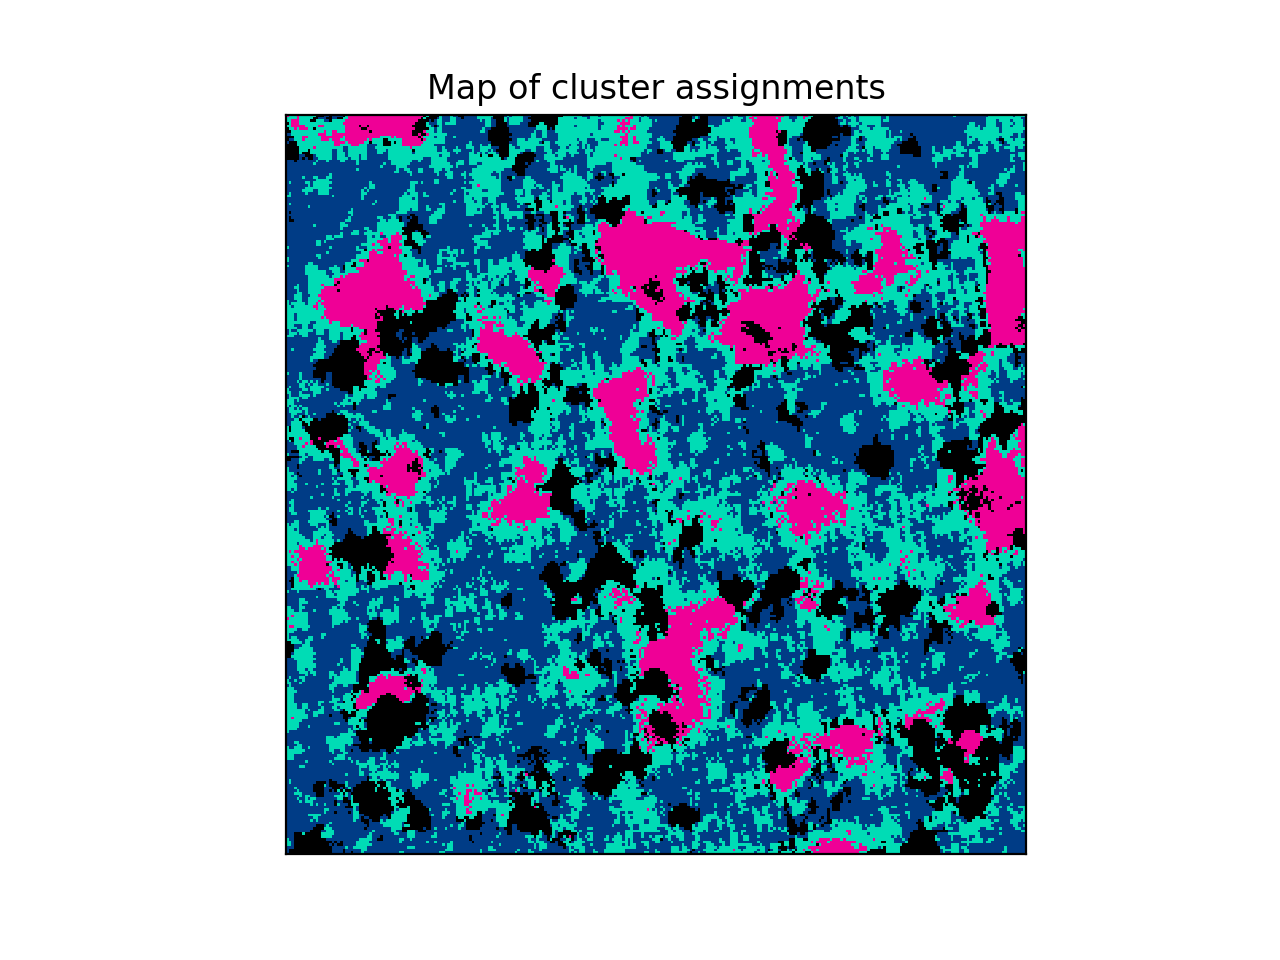

In [21]:
#Import kMeans labels
def import_labels(fileName, delimiter, header):
    dataframe = pd.read_csv(fileName, sep = delimiter, header = header)
    return dataframe.values

labels_5 = import_labels("Rh5_4K_4cluster_labels.csv", ",", None)
print(np.shape(labels_5))

#Define bias values
def bias(minV, maxV, data):
    V = np.linspace(minV, maxV, num=len(data[0][0]))
    V_positive = np.linspace(0.0, maxV, num=(len(data[0][0])-1)//2)
    return V, V_positive

V_5, V_5_positive = bias(-0.8, 0.8, data_5)


#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for D
#                '#00DCB5'is teal for P2
fig,(ax2) = plt.subplots()
fig.subplots_adjust(hspace=0.3)
cmap = colors.ListedColormap(['#EF0096','k','#00DCB5','#003C86'])
ax2.imshow(labels_5, cmap=cmap)
ax2.set_title("Map of cluster assignments")
ax2.set_xticks([])
ax2.set_yticks([])
    
plt.show()

In [34]:
#function to pick out spectra of interest
def spectra_of_interest(data, labels, cluster):
    #Inputs:
    # data : output from MATLAB_file_to_array function, 3D grid map array
    # labels : output from import_labels function, 2D array results from kMeans
    # cluster : the cluster of interest, using number from labels array (ie: for 4 clusters, either 0, 1, 2, or 3)
    #Outputs:
    # spectra : 2D array of all spectra of the given cluster
    # spectra_positive: 2D array of all spectra of a given cluster starting at 0.0 V
    
    #First, make 2D version of data array, ie:(275,275,81)-->(75625, 81)
    data_2D = np.reshape(data, (np.shape(data)[0]*np.shape(data)[1], np.shape(data)[2]))
    
    #Second, make 1D version of labels array, ie:(275,275-->(75625)
    labels_1D = np.reshape(labels, np.shape(labels)[0]*np.shape(labels)[1])

    #Next, pick out the spectra that fall under the specified cluster and add them to a list
    spectra = []
    spectra_positive = []
    for index, label in enumerate(labels_1D):
        if label==cluster: 
            spectra.append(data_2D[index])
            zero_point = (len(data[0][0])-1)//2 + 1
            spectra_positive.append(data_2D[index][zero_point:])
        
    return spectra, spectra_positive


#divide up the spectra into its clusters:
M_spectra, M_spectra_positive = spectra_of_interest(data_5, labels_5, 0)#magenta on saved plot
P1_spectra, P1_spectra_positive = spectra_of_interest(data_5, labels_5, 3)#dark blue on saved plot
D_spectra, D_spectra_positive = spectra_of_interest(data_5, labels_5, 1)#black on saved plot
P2_spectra, P2_spectra_positive = spectra_of_interest(data_5, labels_5, 2)#teal on saved plot

print("There are ",np.shape(M_spectra)[0]," Mott spectra (magenta).")
print("There are ",np.shape(D_spectra)[0]," defect spectra (black).")
print("There are ",np.shape(P1_spectra)[0]," P1 spectra (dark blue).")
print("There are ",np.shape(P2_spectra)[0]," P2 spectra (teal).")


There are  9758  Mott spectra (magenta).
There are  12477  defect spectra (black).
There are  28818  P1 spectra (dark blue).
There are  24572  P2 spectra (teal).


# Fitting Function <br>

In order to find estimates of the function parameters, we want to calculate the likelihood of our data given some parameter values, then find the maximum the likelihood, in order to find the best estimates of the parameters. Note, here I will assume that our data has Gaussiun errors. Then, our -ln(L) is: <br>

$ln(L) = -\frac{1}{2}\sum_{i=1}^{N}{\left(\frac{y_i-f(x_i | \alpha)}{\sigma_i}\right)^2} - \sum_{i=1}^{N}ln(\sigma_{i}\sqrt{2\pi})$ <br>

Maximizing the above (without the loss function, ie: second term) is equivalent to minimizing the following: <br>

$\chi^2 = \sum_{i=1}^{N}{\left(\frac{y_i-f(x_i | \alpha)}{\sigma_i}\right)^2}$ <br>

In order to minimize this, we must first calculate $\sigma_i$, the standard deviation of each x value. Because we are using the sample mean (not a 'true value' mean) in the calculation of the standard deviations, they must be calculated using the following formula: <br>
$\sigma^2 = \frac{1}{N-1}\sum_{i}\left(x_i-\bar{x}\right)^2$

In [44]:
def chi_squared(params, V, spectrum, DOS):
    #DOS : string of the DOS functions to be fitted. Either 'BM', 'BP', or 'BMP'.
    #params : values for all fitted parameters, as a list
    #V: 1D array of bias values
    #spectrum: 1D array containing an individual spectrum of interest
    
    y = spectrum
    f = f_of_x(params, V, DOS)
    elements = [(y[i]-f[i])**2 for i in range(len(y))]
    return np.sum(elements)

    
def f_of_x(params, V, DOS):
    #DOS : string of the DOS functions to be fitted. Either 'BM', 'BP', or 'BMP'.
    #params : values for all fitted parameters, as a list
    #V: array of bias values
    
    if DOS=="BM":
        return DOS_BM(params,V)
        
    elif DOS=="BP":
        return DOS_BP(params,V)
        
    elif DOS=="BMP":
        return DOS_BMP(params,V)
    
    else:
        print("Error: The given DOS string is not a valid option")
        return
    
def minimizer(V, spectra, DOS, params0, bounds):
    #spectra : the spectra of interest to be fit
    #DOS : string of the DOS functions to be fitted. Either 'BM', 'BP', or 'BMP'.
    #params0 : initial guesses for all fitted parameters, as a list
    #bounds : boundary values for all fitted parameters, as a list, ie: ((-1, 1), (0, 10))
    
    #sigma =  np.std(spectra, axis=0, dtype=np.float64, ddof=1) <- not using this.
    
    results = [[] for i in range(len(spectra))]
    for i in tqdm(range(len(spectra))):
        results[i] = optimize.minimize(lambda params: chi_squared(params,V,spectra[i],DOS), params0, bounds=bounds)
    
    return results

In [45]:
#initial guesses of fitting parameters from 'k-means.ipynb'
c0 = -1.5
c1 = 1.0
c2 = 0.85
c3 = 0.0
c4 = 0.6
c5 = 0.3
M = 0.6
P = 0.12
a = 0.2


#bounds for the fitting parameters:
c0_bounds = (-3.0, 3.0) #Cubic background term
c1_bounds = (0.5, 4.0) #Quadratic background term
c2_bounds = (-0.5, 1.0) #Linear background term
c3_bounds = (-0.2, 0.4) #0th order background term
c4_bounds = (0.3, 1.5) #Mott term prefactor
c5_bounds = (0.2,0.7) #Pseudogap term prefactor
M_bounds = (0.3,0.9) #Size of Mott gap in eV
P_bounds = (0.05, 0.3) #Size of pseudogap in eV
a_bounds = (0.1,0.7)# depth of pseudogap


In [55]:
#P1 Fitting:
params0 = [c0, c1, c2, c3, c5, P, a] #Initial estimates for fitting variables
params0 = np.asarray(params0)
bounds = (c0_bounds, c1_bounds, c2_bounds, c3_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params


results = minimizer(V_5, P1_spectra, "BP", params0, bounds) 

100%|██████████| 28961/28961 [23:32<00:00, 20.51it/s] 


In [56]:
#P2 Fitting:
params0 = np.asarray([c0, c1, c2, c3, c5, P, a]) #Initial estimates for fitting variables

bounds = (c0_bounds, c1_bounds, c2_bounds, c3_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params


P2_results = minimizer(V_5, P2_spectra, "BP", params0, bounds) 

100%|██████████| 24494/24494 [19:49<00:00, 22.84it/s]


In [46]:
#M Fitting:
params0 = np.asarray([c0, c1, c2, c3, c4, M]) #Initial estimates for fitting variables

bounds = (c0_bounds, c1_bounds, c2_bounds, c3_bounds, c4_bounds, M_bounds) #Boundary for params


M_results_positive = minimizer(V_5_positive, M_spectra_positive, "BM", params0, bounds) 

100%|██████████| 9758/9758 [00:16<00:00, 592.87it/s]


In [60]:
#D Fitting:
params0 = np.asarray([c0, c1, c2, c3, c4, M, c5, P, a]) #Initial estimates for fitting variables

bounds = (c0_bounds, c1_bounds, c2_bounds, c3_bounds, c4_bounds, M_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params


D_results = minimizer(V_5, D_spectra, "BMP", params0, bounds) 

#Graphically testing what the appropriate bounds are:
v = np.linspace(-0.8, 0.8, 81)
spectrum = P1_spectra[0]

#params =  [ c0, c1,  c2, c3, c5,  P,  a]
y = DOS_BP([-0.7,0.8,0.2,0.0,0.5,0.1,0.8], v, spectrum)

#Plotting the test functions:
#Inertia Plots
fig,(ax) = plt.subplots()
plt.rcParams.update({'font.size': 12})
ax.plot(v, y, marker='.',linestyle='-', lw=1, label='real')
ax.set_ylabel("DOS")
ax.set_xlabel("V")
ax.set_xlim([-0.81,0.81])
ax.set_ylim([-0.25,1.0])
ax.legend()

plt.show()

100%|██████████| 12461/12461 [01:43<00:00, 119.83it/s]


<IPython.core.display.Javascript object>


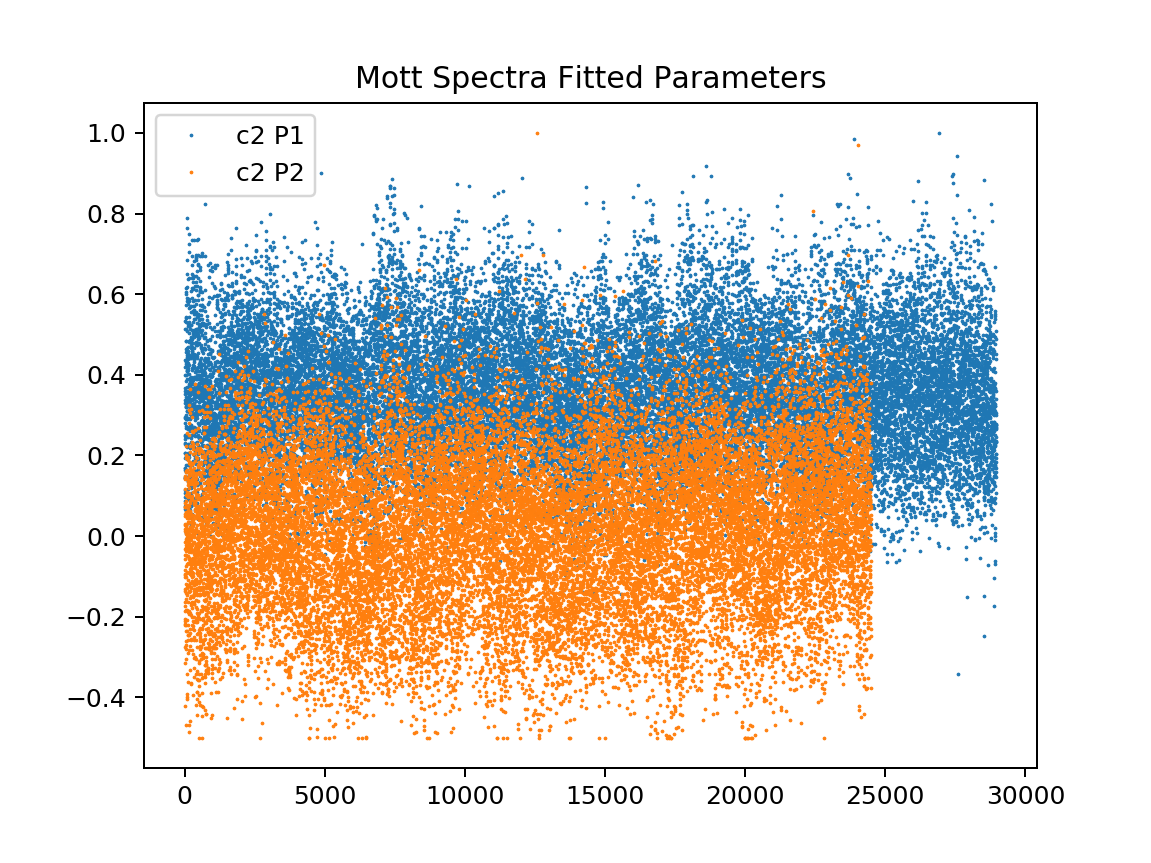

In [95]:
#Plot the fitted parameters:
#P1
x_values_P1 = np.linspace(0, len(results),len(results))
y_values_1 = [0 for i in range(len(results))]
for i in range(len(results)):
    y_values_1[i] = results[i].x[0]
    
y_values_2 = [0 for i in range(len(results))]
for i in range(len(results)):
    y_values_2[i] = results[i].x[1]
    
y_values_3 = [0 for i in range(len(results))]
for i in range(len(results)):
    y_values_3[i] = results[i].x[2]
    
y_values_4 = [0 for i in range(len(results))]
for i in range(len(results)):
    y_values_4[i] = results[i].x[3]
    
y_values_5 = [0 for i in range(len(results))]
for i in range(len(results)):
    y_values_5[i] = results[i].x[4]
    
y_values_6 = [0 for i in range(len(results))]
for i in range(len(results)):
    y_values_6[i] = results[i].x[5]
    
y_values_7 = [0 for i in range(len(results))]
for i in range(len(results)):
    y_values_7[i] = results[i].x[6]

    
#P2
x_values_P2 = np.linspace(0, len(P2_results),len(P2_results))
y_values_A = [0 for i in range(len(P2_results))]
for i in range(len(P2_results)):
    y_values_A[i] = P2_results[i].x[0]
    
y_values_B = [0 for i in range(len(P2_results))]
for i in range(len(P2_results)):
    y_values_B[i] = P2_results[i].x[1]
    
y_values_C = [0 for i in range(len(P2_results))]
for i in range(len(P2_results)):
    y_values_C[i] = P2_results[i].x[2]
    
y_values_D = [0 for i in range(len(P2_results))]
for i in range(len(P2_results)):
    y_values_D[i] = P2_results[i].x[3]
    
y_values_E = [0 for i in range(len(P2_results))]
for i in range(len(P2_results)):
    y_values_E[i] = P2_results[i].x[4]
    
y_values_F = [0 for i in range(len(P2_results))]
for i in range(len(P2_results)):
    y_values_F[i] = P2_results[i].x[5]
    
y_values_G = [0 for i in range(len(P2_results))]
for i in range(len(P2_results)):
    y_values_G[i] = P2_results[i].x[6]
    


fig, ax = plt.subplots()
#ax.plot(x_values_P1,y_values_1,label="c0 P1", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P1,y_values_2,label="c1 P1", marker='.',linestyle='',markersize=1)
ax.plot(x_values_P1,y_values_3,label="c2 P1", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P1,y_values_4,label="c3 P1", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P1,y_values_5,label="c5 P1", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P1,y_values_6,label="P P1", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P1,y_values_7,label="a P1", marker='.',linestyle='',markersize=1)

#ax.plot(x_values_P2,y_values_A,label="c0 P2", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P2,y_values_B,label="c1 P2", marker='.',linestyle='',markersize=1)
ax.plot(x_values_P2,y_values_C,label="c2 P2", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P2,y_values_D,label="c3 P2", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P2,y_values_E,label="c5 P2", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P2,y_values_F,label="P P2", marker='.',linestyle='',markersize=1)
#ax.plot(x_values_P2,y_values_G,label="a P2", marker='.',linestyle='',markersize=1)

ax.set_title("Mott Spectra Fitted Parameters")
ax.legend()